In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

#  [1] 파생변수 생성 함수 (데이터 누수 방지) 

In [3]:
def add_custom_features(df):
    X = df.copy()
    X['HasBalance'] = (X['Balance'] > 0).astype(int)
    X['BalanceSalaryRatio'] = X['Balance'] / (X['EstimatedSalary'] + 1e-6)
    X['Age_Group'] = pd.cut(X['Age'], bins=[0, 30, 45, 60, 100], labels=[0, 1, 2, 3]).astype(int)
    X['Prod_is_1'] = (X['NumOfProducts'] == 1).astype(int)
    X['Prod_is_2'] = (X['NumOfProducts'] == 2).astype(int)
    X['Prod_ge_3'] = (X['NumOfProducts'] >= 3).astype(int)
    X['ZeroBal_Prod1'] = ((X['Balance'] == 0) & (X['NumOfProducts'] == 1)).astype(int)
    X['ZeroBal_Prod2'] = ((X['Balance'] == 0) & (X['NumOfProducts'] == 2)).astype(int)
    X['Prod2_Inactive'] = ((X['NumOfProducts'] == 2) & (X['IsActiveMember'] == 0)).astype(int)
    X['Inactive_Old'] = ((X['IsActiveMember'] == 0) & (X['Age'] >= 45)).astype(int)
    return X

# [2] 데이터 로드 및 전처리 

# 데이터 불러오기

In [4]:
df = pd.read_csv('Customer-Churn-Records.csv')
df_enriched = add_custom_features(df)

In [5]:
#'Complain' 변수는 데이터 누수(Data Leakage)이므로 제거

target = 'Exited'
drop_cols = ['RowNumber', 'CustomerId', 'Surname', 'Complain', target]
X = df_enriched.drop(columns=drop_cols)
y = df_enriched[target]

In [6]:
# CatBoost가 처리할 범주형 변수 리스트 지정

cat_features = ['Geography', 'Gender', 'Card Type']

In [7]:
# 데이터 분할 (8:2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#  [3] CatBoost 하이퍼파라미터 튜닝 (GridSearchCV) 

In [8]:
# 모델 생성 (cat_features는 fit 단계에서 넣어 에러를 방지합니다)

cat_base = CatBoostClassifier(
    silent=True, 
    random_seed=42,
    thread_count=-1, # CPU 전체 코어 사용
    max_ctr_complexity=4
)

In [9]:
# 튜닝할 파라미터 조합

param_grid = {
    'iterations': [300, 500],
    'depth': [4, 6],
    'learning_rate': [0.03, 0.05],
    'scale_pos_weight': [2, 3] # 이탈 데이터 불균형 대응
}

In [10]:
# GridSearchCV 설정 (verbose=2로 진행 상황 확인)

grid_search = GridSearchCV(
    estimator=cat_base,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

In [11]:
# 학습 시작 
grid_search.fit(X_train, y_train, cat_features=cat_features)

,estimator,"CatBoostClass..., silent=True)"
,param_grid,"{'depth': [4, 6], 'iterations': [300, 500], 'learning_rate': [0.03, 0.05], 'scale_pos_weight': [2, 3]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


In [12]:
# 최적 모델 저장
best_cat_model = grid_search.best_estimator_
print(f"\n 최적 파라미터 탐색 완료: {grid_search.best_params_}")


 최적 파라미터 탐색 완료: {'depth': 4, 'iterations': 300, 'learning_rate': 0.03, 'scale_pos_weight': 3}


#  [4] 최종 모델 평가 (임계값 0.4 적용) 

In [13]:
probs = best_cat_model.predict_proba(X_test)[:, 1]
preds = (probs >= 0.4).astype(int)

In [14]:
print("\n" + "="*60)
print(" [Tuned CatBoost Final Report]")
print(f"Final AUC Score: {roc_auc_score(y_test, probs):.4f}")
print("-" * 60)
print(classification_report(y_test, preds))
print("="*60)


 [Tuned CatBoost Final Report]
Final AUC Score: 0.8812
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      1592
           1       0.48      0.81      0.60       408

    accuracy                           0.78      2000
   macro avg       0.71      0.79      0.73      2000
weighted avg       0.85      0.78      0.80      2000



# [5] 결과 시각화 (중요도 및 ROC Curve) 

In [15]:
plt.figure(figsize=(16, 7))

<Figure size 1600x700 with 0 Axes>

<Figure size 1600x700 with 0 Axes>

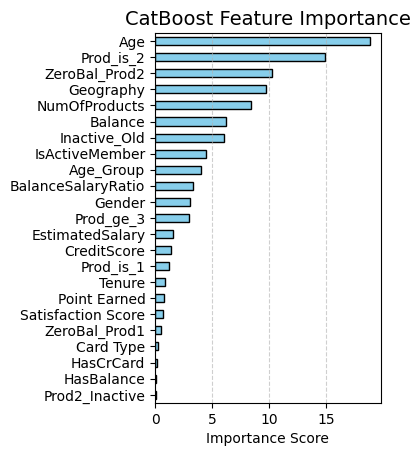

In [16]:
# (1) 변수 중요도 시각화

plt.subplot(1, 2, 1)
feature_imp = pd.Series(best_cat_model.get_feature_importance(), index=X.columns)
feature_imp.sort_values(ascending=True).plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('CatBoost Feature Importance', fontsize=14)
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.6)

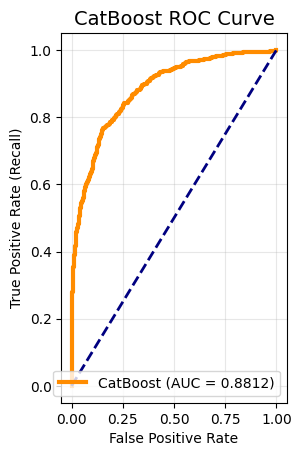

In [17]:
# (2) ROC 커브 시각화

plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'CatBoost (AUC = {roc_auc_score(y_test, probs):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('CatBoost ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

In [18]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>